In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import click

**Pre-processing Dataset**

In [2]:
def plot_similarity(labels1, labels2, features1, features2, rotation):
    corr = np.inner(features1, features2)
    corr2 = corr.copy()
    corr2[corr2<0.8]=0
    corr2[corr2>=0.8]=1
    #print(corr)
    sns.set(font_scale=0.6)
    #plt.figure(figsize=(100,100))
    g = sns.heatmap(corr,\
        #xticklabels=labels1,\
        #yticklabels=labels2,\
        vmin=0,\
        vmax=1,\
        #cmap="Greys")
        cmap="YlOrRd")
    #g.set_xticklabels(labels1, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    plt.tight_layout()
    plt.savefig("Quora.png")
    plt.show()
    #plt.figure(figsize=(100,100))
    #g.set_xticklabels(labels1, rotation=rotation)
    similar_qid = {}
    for i in range(len(labels1)):
        for j in range(len(labels2)):
            if corr2[i][j] == 1:
                similar_qid[labels1[i]]=labels2[j]
    return similar_qid

In [3]:
def run_and_plot(session_, input_tensor_, messages1_, messages2_, labels1_,labels2_, encoding_tensor):
    print("Embeddings questions 1")
    message_embeddings1_ = session_.run(encoding_tensor, feed_dict={input_tensor_: messages1_})
    print("Embeddings questions 2")
    message_embeddings2_ = session_.run(encoding_tensor, feed_dict={input_tensor_: messages2_})
    similar_qid = plot_similarity(labels1_,labels2_, \
            message_embeddings1_,\
            message_embeddings2_, 90)
    return similar_qid

**Read data, remove duplication, then using heatmap to display similarity**

Loading data from q_quora.csv
Data loaded successfully
Loading model from https://tfhub.dev/google/universal-sentence-encoder/2
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 128.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 248.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 368.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 488.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 608.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 738.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 868.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentenc

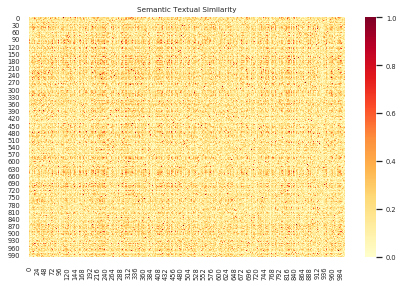

In [5]:
fname = "q_quora.csv"
numlines = 1000 # Number of lines to read

question1 = {}
question2 = {}

print("Loading data from {}".format(fname))

with open(fname,'r') as f:
    if numlines == -1:
        totalLines = f.readlines()[1:]
    else:
        totalLines = f.readlines()[1:numlines]
    for line in totalLines:
        try:
            qid1, qid2, q1, q2 = line.strip().split(',')[1:5]
            question1[qid1] = q1
            question2[qid2] = q2
        except:
            continue

print("Data loaded successfully")

module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
# module_url = "https://216.239.32.27/google/universal-sentence-encoder/2"
print("Loading model from {}".format(module_url))
embed = hub.Module(module_url)
print("Model loaded successfully")

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    similar_qid = run_and_plot(session, similarity_input_placeholder,\
            list(question1.values()),\
            list(question2.values()),\
            list(question1.keys()),\
            list(question2.keys()),\
            similarity_message_encodings)

with open("similarity-results.txt",'w') as f:
    for i in list(similar_qid.keys()):
        f.write("{},{}\n=======================\n".format(question1[i], question2[similar_qid[i]]))